# Read the dataset

In [2]:
from glob import glob
from pathlib import Path
import torch
from torchvision.models import vgg16, vgg16_bn, VGG16_BN_Weights
from torchvision.io import read_image
from torchvision.datasets import ImageFolder, CIFAR10
from torch.utils.data import Subset, DataLoader
import numpy as np
import json


def measure_intraclass_similarity(model, dataset, device="cuda:0"):
  mi = dict()
  for class_name, class_idx in dataset.class_to_idx.items():
    class_idxs = torch.where(torch.tensor(dataset.targets) == class_idx)[0]
    class_subset = Subset(dataset, class_idxs)

    dl = DataLoader(class_subset, batch_size=256)
    representations = None

    for batch, target in dl:
      with torch.no_grad():
        prediction = model(batch.to(device))

        if representations is None:
          representations = prediction
        else:
          representations = torch.vstack([representations, prediction])

    representations = representations / torch.norm(representations, p=2, dim=1).reshape(-1, 1)
    mi[class_name] = (representations @ representations.T).mean().item()
  return mi

In [3]:
features = json.load(Path("/home/nicolas/projects/ARTstract-KG/main/ARTstract_kg_construction/ACC_creation/combined_data.json").open())

In [4]:
import json
import numpy as np
from pathlib import Path
import pandas as pd

def extract_dict(json_path: Path):
  perceptional = json.load(json_path.open())
  
  images = []
  for image_id in perceptional.keys():
    image_d = dict()
    image_d["id"] = image_id
    
    image_data = perceptional[image_id]
    # extract action
    k = next(iter(image_data["act"].keys()))
    image_d["action"] = image_data["act"][k]["action_label"]
    
    # extract emotions
    k = next(iter(image_data["em"].keys()))
    image_d["emotion"] = image_data["em"][k]["emotion"]

    # detected objects
    k = next(iter(image_data["od"].keys()))
    # at most 5 objects
    objects = list(set(jo["detected_object"] for jo in image_data["od"][k]["detected_objects"]))
    for i in range(5):
      image_d[f"object_{i}"] = objects[i] if i < len(objects) else ""
    
    # art style
    k = next(iter(image_data["as"].keys()))
    image_d["art_style"] = image_data["as"][k]["art_style"]
    
    # color
    k = next(iter(image_data["color"].keys()))
    # at most 5 colors
    colors = list(set(jo["webcolor_name"] for jo in image_data["color"][k]))
    for i in range(5):
      image_d[f"color_{i}"] = colors[i] if i < len(colors) else ""
        
    # human-presence
    #k = next(iter(image_data["hp"].keys()))
    #image_d["human_presence"] = image_data["hp"][k]["human_presence"]
    
    # age detected
    k = next(iter(image_data["age"].keys()))
    image_d["age"] = image_data["age"][k]["age_tier"]

    # add cluster
    image_d["cluster"] = image_data["cluster"]
    
    images.append(image_d)
  return images

# Bayesan

In [5]:
from itertools import combinations

import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from pgmpy.estimators import PC, HillClimbSearch, ExhaustiveSearch
from pgmpy.estimators import K2Score
from pgmpy.utils import get_example_model
from pgmpy.sampling import BayesianModelSampling

import pandas as pd

In [8]:
from itertools import combinations

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, ExpectationMaximization, BayesianEstimator
from pgmpy.inference import VariableElimination

from sklearn.model_selection import train_test_split

PATH = Path("/home/nicolas/projects/ARTstract-KG/main/perceptual_semantics_detection/merged_data.json")
data = extract_dict(PATH)

dataset = pd.DataFrame(data).drop([
  "id", 
  #"color_0", 
  #"color_1", 
  #"color_2", 
  "color_3", 
  "color_4", 
  #"object_0", 
  #"object_1", 
  #"object_2", 
  "object_3", 
  "object_4",
  ], axis=1)
X_train, X_test = train_test_split(dataset, test_size=0.33, random_state=42)

model = BayesianNetwork([
  ('cluster', 'age'), ('cluster', 'art_style'), ('cluster', 'action'), ('cluster', 'emotion'),
  
  ('cluster', 'color_0'), 
  ('cluster', 'color_1'), 
  ('cluster', 'color_2'),
  #('cluster', 'color_3'),
  #('cluster', 'color_4'),
  ('emotion', 'color_0'), 
  ('emotion', 'color_1'), 
  ('emotion', 'color_2'),
  #('emotion', 'color_3'),
  #('emotion', 'color_4'),

  ('cluster', 'object_0'), 
  ('cluster', 'object_1'), 
  ('cluster', 'object_2'),
  #('cluster', 'object_3'),
  #('cluster', 'object_4'),
  ('object_0', 'action'), 
  ('object_1', 'action'), 
  ('object_2', 'action'),
  #('object_3', 'action'), 
  #('object_4', 'action'),
  *list(combinations([
    "object_0",
    "object_1", 
    "object_2",
    #"object_3",
    #"object_4"
  ], 2))
])

model.fit(X_train, estimator=MaximumLikelihoodEstimator)

In [9]:
from pgmpy.inference import VariableElimination
from sklearn.metrics import classification_report
from tqdm import tqdm

infer = VariableElimination(model)

preds = {}
MAP_QUERY = infer.map_query(["cluster"])["cluster"]

for row_idx, row in tqdm(X_test.drop(["cluster"], axis=1).iterrows()):
  try:
    out = infer.query(["cluster"], evidence=row.to_dict())
    labels = out.state_names["cluster"]
    preds[row_idx] = labels[out.values.argmax()]
  except KeyboardInterrupt:
    break
  except:
    preds[row_idx] = MAP_QUERY

print(classification_report(X_test.loc[preds.keys(), "cluster"], list(preds.values())))

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]/home/nicolas/.conda/envs/mosaic/lib/python3.11/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
4883it [00:02, 1714.88it/s]

              precision    recall  f1-score   support

     comfort       0.52      0.76      0.62      2062
      danger       0.15      0.07      0.10       358
       death       0.33      0.29      0.31       879
     fitness       0.11      0.04      0.06       307
     freedom       0.11      0.04      0.06       169
       power       0.30      0.21      0.25       983
      safety       0.13      0.06      0.08       125

    accuracy                           0.43      4883
   macro avg       0.24      0.21      0.21      4883
weighted avg       0.36      0.43      0.38      4883



In [12]:
from pgmpy.estimators import HillClimbSearch, ExhaustiveSearch, MmhcEstimator
from pgmpy.estimators import BDeuScore, K2Score, BicScore

hc = HillClimbSearch(X_train)
model = hc.estimate(scoring_method=BDeuScore(X_train))

model = BayesianNetwork(model)
model.fit(X_train, estimator=MaximumLikelihoodEstimator)

  0%|          | 8/1000000 [00:01<68:44:51,  4.04it/s] 


In [13]:
from pgmpy.inference import VariableElimination
from sklearn.metrics import classification_report
from tqdm import tqdm

infer = VariableElimination(model)

preds = {}
MAP_QUERY = infer.map_query(["cluster"])["cluster"]

for row_idx, row in tqdm(X_test.drop(["cluster"], axis=1).iterrows()):
  try:
    out = infer.query(["cluster"], evidence=row.to_dict())
    labels = out.state_names["cluster"]
    preds[row_idx] = labels[out.values.argmax()]
  except KeyboardInterrupt:
    break
  except:
    preds[row_idx] = MAP_QUERY

print(classification_report(X_test.loc[preds.keys(), "cluster"], list(preds.values())))

Eliminating: art_style: 100%|██████████| 2/2 [00:00<00:00, 3313.04it/s]
0it [00:00, ?it/s]/home/nicolas/.conda/envs/mosaic/lib/python3.11/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:478: RuntimeWarning: invalid value encountered in divide
  phi.values = phi.values / phi.values.sum()
4883it [00:03, 1609.11it/s]

              precision    recall  f1-score   support

     comfort       0.56      0.76      0.65      2062
      danger       0.00      0.00      0.00       358
       death       0.36      0.41      0.39       879
     fitness       0.00      0.00      0.00       307
     freedom       0.00      0.00      0.00       169
       power       0.30      0.33      0.31       983
      safety       0.00      0.00      0.00       125

    accuracy                           0.46      4883
   macro avg       0.17      0.21      0.19      4883
weighted avg       0.36      0.46      0.41      4883




/home/nicolas/.conda/envs/mosaic/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nicolas/.conda/envs/mosaic/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nicolas/.conda/envs/mosaic/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result

In [ ]:
print(infer.query(variables=["cluster"]))
print(infer.query(variables=["cluster"], evidence={"action": "running", "emotion": "fear", "object_1": "truck"}))

+------------------+----------------+
| cluster          |   phi(cluster) |
+==================+================+
| cluster(comfort) |         0.4200 |
+------------------+----------------+
| cluster(danger)  |         0.0736 |
+------------------+----------------+
| cluster(death)   |         0.1867 |
+------------------+----------------+
| cluster(fitness) |         0.0620 |
+------------------+----------------+
| cluster(freedom) |         0.0347 |
+------------------+----------------+
| cluster(power)   |         0.1966 |
+------------------+----------------+
| cluster(safety)  |         0.0264 |
+------------------+----------------+
+------------------+----------------+
| cluster          |   phi(cluster) |
+==================+================+
| cluster(comfort) |         0.2174 |
+------------------+----------------+
| cluster(danger)  |         0.0758 |
+------------------+----------------+
| cluster(death)   |         0.2703 |
+------------------+----------------+
| cluster(fi

# VGG

In [ ]:
weights = VGG16_BN_Weights.IMAGENET1K_V1

model = vgg16_bn(weights=weights).to("cuda:0")
model.classifier[-1] = torch.nn.Identity()
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
cifar10 = CIFAR10("/home/nicolas/projects/ARTstract-KG/cifar10", train=False, transform=weights.transforms())
cifar10_mi = measure_intraclass_similarity(model, cifar10)
cifar10_mi

KeyboardInterrupt: 

In [ ]:
artstract = ImageFolder("/home/nicolas/projects/ARTstract-KG/dataset/", transform=weights.transforms())
artstract_mi = measure_mutual_information(model, artstract)
artstract_mi

{'comfort': 0.3761897087097168,
 'danger': 0.3303679823875427,
 'death': 0.36643069982528687,
 'fitness': 0.34907782077789307,
 'freedom': 0.3249892592430115,
 'power': 0.35132113099098206,
 'safety': 0.3088183104991913}

In [ ]:
weights = VGG16_BN_Weights.IMAGENET1K_V1

model = vgg16_bn(weights=weights).to("cuda:0")
model.classifier[-1] = torch.nn.Identity()
model.eval()

# Information theory

In [ ]:
from string import printable
from collections import Counter

class SampleEncoder:
  def __init__(self, data):
    self.value_map = dict()
    self.value_map_inv = dict()

    for key in data[0].keys():
      if key != "id":
        values = list(set(sample[key] for sample in data))
        self.value_map[key] = dict(zip(values, [printable[i] for i in range(len(values))]))
        self.value_map_inv[key] = dict(zip([printable[i] for i in range(len(values))], values))

  @property
  def keys(self):
    return list(self.value_map.keys())

  def encode(self, sample):
    encoded = ""
    for k, v in sample.items():
      if k in self.value_map:
        encoded += self.value_map[k][v]
    return encoded

  def decode(self, encoded):
    return {
      key: self.value_map_inv[key][encoded_val]
      for key, encoded_val in zip(self.value_map_inv.keys(), encoded)
    }


In [ ]:
import dit

class InluenceOnCluster:
  def __init__(self, data):
    self.data = data
    self.se = SampleEncoder(data)
    count = Counter([se.encode(d) for d in data])
    pmf = { k: v /  sum(count.values()) for k, v in count.items() }

    # encode variable names
    self.dist = dit.Distribution(pmf)
    self.var_map = { k: printable[idx] for idx, k in enumerate(se.keys)}
    self.dist.set_rv_names(list(self.var_map.values()))

  @property
  def variables(self):
    return list(self.var_map.keys())

  def subset(self, value, on: str = "cluster"):
    data_subset = [s for s in self.data if s[on] == value]
    return InluenceOnCluster(data_subset)

  def conditional_entropy(self, *elements, on: str = "cluster"):
    return dit.multivariate.entropy(self.dist, 
      rvs="".join([self.var_map[e] for e in elements]),
      crvs=self.var_map[on] if on != None else None, 
      rv_mode="names")

it = InluenceOnCluster(data)

NameError: name 'se' is not defined

Which is the perceptional feature holding the most information?

<Axes: >

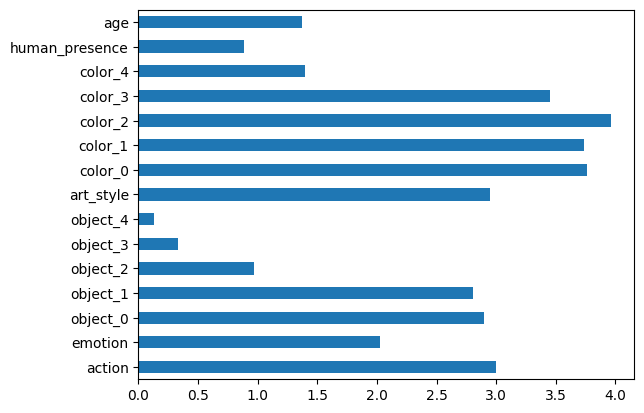

In [ ]:
import pandas as pd
pd.Series({var: it.conditional_entropy(var) for var in it.variables if var != "cluster"}).plot.barh()

What about cluster by cluster?

<Axes: >

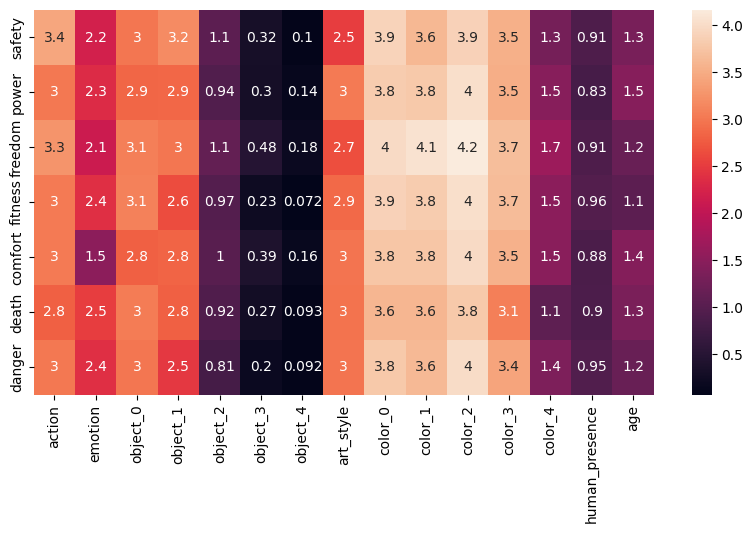

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

entropy_by_cluster = []
for cluster in set([s["cluster"] for s in data]):
  cluster_it = it.subset(cluster)
  entropy_by_cluster.append([cluster_it.conditional_entropy(var) for var in cluster_it.variables if var != "cluster"])

plt.figure(figsize=(10, 5))
sns.heatmap(
  pd.DataFrame(entropy_by_cluster, index=list(set([s["cluster"] for s in data])), columns=[v for v in it.variables if v != "cluster"]), 
  annot=True)

# ML Stuff

In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

feature_encoder = OneHotEncoder().fit(dataset.drop("cluster", axis=1))
label_encoder = LabelEncoder().fit(dataset["cluster"])

clfs = [DecisionTreeClassifier(), RandomForestClassifier(), HistGradientBoostingClassifier(), MultinomialNB(), LinearSVC()]

for clf in clfs:
  X_train_enc = feature_encoder.transform(X_train.drop("cluster", axis=1)).toarray()
  y_train_enc = label_encoder.transform(X_train["cluster"])
  clf.fit(X_train_enc, y_train_enc)

  X_test_enc = feature_encoder.transform(X_test.drop("cluster", axis=1)).toarray()
  y_test_enc = label_encoder.transform(X_test["cluster"])

  y_pred = clf.predict(X_test_enc)
  print("-" * 10)
  print(clf)
  print(classification_report(y_test_enc, y_pred))

----------
DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.55      0.57      0.56      2062
           1       0.09      0.07      0.08       358
           2       0.29      0.32      0.31       879
           3       0.06      0.05      0.05       307
           4       0.05      0.05      0.05       169
           5       0.26      0.26      0.26       983
           6       0.13      0.10      0.11       125

    accuracy                           0.36      4883
   macro avg       0.20      0.20      0.20      4883
weighted avg       0.35      0.36      0.36      4883

----------
RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.56      0.82      0.66      2062
           1       0.10      0.02      0.03       358
           2       0.36      0.37      0.37       879
           3       0.22      0.03      0.05       307
           4       0.15      0.02      0.03       169
      

In [17]:
import warnings
warnings.filterwarnings("ignore")

clusters = dataset["cluster"].unique()
augment = None
for cluster in clusters:
  synth = model.simulate(n_samples=2000, evidence={"cluster": cluster}, show_progress=False)
  augment = synth if augment is None else pd.concat([augment, synth])  

for clf in clfs:
  augmented_X = pd.concat([X_train, augment])
  
  X_train_enc = feature_encoder.transform(augmented_X.drop("cluster", axis=1)).toarray()
  y_train_enc = label_encoder.transform(augmented_X["cluster"])
  clf.fit(X_train_enc, y_train_enc)

  X_test_enc = feature_encoder.transform(X_test.drop("cluster", axis=1)).toarray()
  y_test_enc = label_encoder.transform(X_test["cluster"])

  y_pred = clf.predict(X_test_enc)
  print("-" * 10)
  print(clf)
  print(classification_report(y_test_enc, y_pred))

----------
DecisionTreeClassifier()
              precision    recall  f1-score   support

           0       0.57      0.43      0.49      2062
           1       0.08      0.11      0.09       358
           2       0.29      0.27      0.27       879
           3       0.07      0.10      0.08       307
           4       0.05      0.11      0.06       169
           5       0.24      0.19      0.22       983
           6       0.04      0.13      0.07       125

    accuracy                           0.29      4883
   macro avg       0.19      0.19      0.18      4883
weighted avg       0.35      0.29      0.32      4883

----------
RandomForestClassifier()
              precision    recall  f1-score   support

           0       0.58      0.71      0.64      2062
           1       0.12      0.08      0.10       358
           2       0.36      0.37      0.36       879
           3       0.09      0.06      0.07       307
           4       0.09      0.08      0.08       169
      

# Visual

In [ ]:
from diffusers import DiffusionPipeline
generator = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", use_safetensors=True)
generator.to("cuda:0")

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.95it/s]


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.21.2",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
TEMPLATE = "An image that evokes {cluster} and depicts {emotion} in {art_style} style with colors {color_0} and {color_1} containing a depiction of {object_0}"

In [ ]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)

In [ ]:
elem_0 = "color_2"
elem_1 = "object_2"
elem_2 = "emotion"

phi = infer.query(variables=[elem_0, elem_1, elem_2], evidence={"cluster": "comfort"})
idx_0, idx_1, idx_2 = np.unravel_index(phi.values.argmax(), phi.values.shape)
phi.state_names[elem_0][idx_0], phi.state_names[elem_1][idx_1], phi.state_names[elem_2][idx_2]

('gray', '', 'contentment')

('sleeping', 'contentment')

In [ ]:
print(phi)

+----------------------------+---------------+
| action                     |   phi(action) |
+============================+===============+
| action(calling)            |        0.0110 |
+----------------------------+---------------+
| action(clapping)           |        0.0357 |
+----------------------------+---------------+
| action(cycling)            |        0.0132 |
+----------------------------+---------------+
| action(dancing)            |        0.2103 |
+----------------------------+---------------+
| action(drinking)           |        0.0361 |
+----------------------------+---------------+
| action(eating)             |        0.0075 |
+----------------------------+---------------+
| action(fighting)           |        0.0283 |
+----------------------------+---------------+
| action(hugging)            |        0.0146 |
+----------------------------+---------------+
| action(laughing)           |        0.0353 |
+----------------------------+---------------+
| action(list

In [ ]:
dataset.object_0.unique()

array(['person', '', 'cow', 'vase', 'horse', 'broccoli', 'bird', 'bowl',
       'sheep', 'tv', 'cake', 'handbag', 'bear', 'clock', 'skateboard',
       'bench', 'potted plant', 'dining table', 'cup', 'carrot', 'kite',
       'cell phone', 'car', 'tie', 'umbrella', 'bicycle', 'dog', 'boat',
       'apple', 'cat', 'suitcase', 'sports ball', 'bed', 'truck',
       'teddy bear', 'backpack', 'tennis racket', 'book', 'knife',
       'toilet', 'scissors', 'pizza', 'donut', 'traffic light',
       'elephant', 'toothbrush', 'banana', 'couch', 'stop sign', 'bottle',
       'hot dog', 'chair', 'refrigerator', 'fire hydrant', 'giraffe',
       'laptop', 'surfboard', 'keyboard', 'zebra', 'train', 'frisbee',
       'airplane', 'bus', 'orange', 'baseball bat', 'snowboard', 'fork',
       'oven', 'skis', 'motorcycle', 'sandwich', 'remote', 'microwave',
       'mouse', 'spoon', 'baseball glove', 'wine glass', 'toaster',
       'sink', 'parking meter'], dtype=object)








  0%|          | 0/1 [01:31<?, ?it/s]
















100%|██████████| 50/50 [00:06<00:00,  7.53it/s]


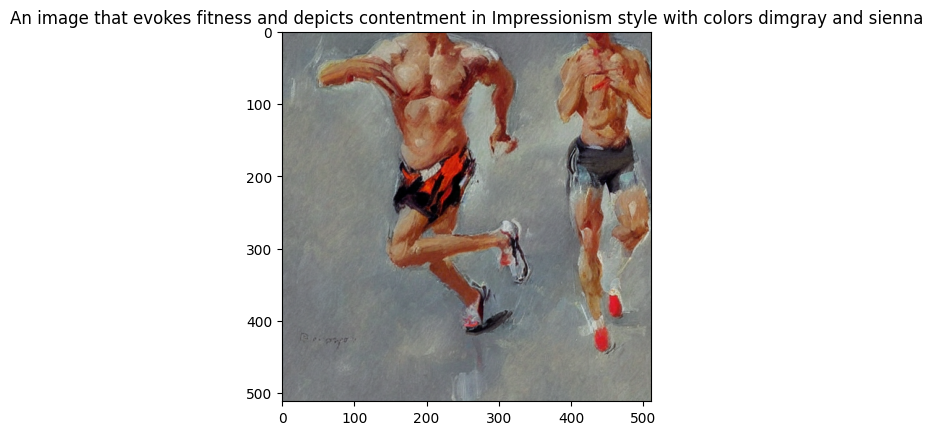

In [ ]:
sample = model.simulate(n_samples=1, evidence={"cluster": "fitness", "object_0": "broccoli"})
text = TEMPLATE.format(**sample.iloc[0].to_dict())
image = generator(text).images[0]

plt.title(text)
plt.imshow(np.asarray(image))